In [3]:
#-----------------------Data Preprocessing----------------
import librosa
import os
import math
import json

import warnings
warnings.filterwarnings("ignore")

SAMPLE_RATE=22050
DURATION=2
SAMPLES_PER_TRACK=SAMPLE_RATE*DURATION

DATASET_PATH="../input/gunshot-audio-dataset"
JSON_PATH="./dataset_JSON.json"
def save_mfcc(dataset_path,json_path,num_segments,n_mfcc=13,n_fft=2048,hop_length=512):
    
    #dictonary to store data (Schema)
    data={
        #"mapping":[],
        "mfcc":[],
        "class label":[],
        "filename":[],
        "class name":[]
    }
    
    num_samples_per_segment=int(SAMPLES_PER_TRACK/num_segments)
    expected_num_mfcc_vectors_per_segment=math.ceil(num_samples_per_segment/hop_length) #1.2->2
    
    #loop through all the genres
    for i,(dirpath,dirnames,filenames) in enumerate(os.walk(dataset_path)):
        #ensure that we are not at root lebvel
        if dirpath is not dataset_path:
            #save the semantic label
            dirpath_components=dirpath.split("/") #genre/blues=>["genre","blues"]
            semantic_label=dirpath_components[-1] #take only "blues"
            
            #data["mapping"].append(semantic_label)
            #process files for a specific genre
            for f in filenames:
                fn=f.split("(")
                class_number=fn[0]
                filename=fn[1].split(")")
                filename=filename[0]
                #print(semantic_label)
                
                #load audio file
                file_path=os.path.join(dirpath,f)
                signal,sr=librosa.load(file_path,sr=SAMPLE_RATE)
                #process segments extracting mfcc and storing data
                for s in range(num_segments):
                    start_sample=num_samples_per_segment*s
                    finish_sample=start_sample+num_samples_per_segment
                    mfcc=librosa.feature.mfcc(signal[start_sample:finish_sample],sr=sr,n_fft=n_fft,n_mfcc=n_mfcc,hop_length=hop_length)
                    mfcc=mfcc.T
                    #store mfcc for segment if it has the expected length
                    if len(mfcc)==expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["class label"].append(class_number)
                        data["filename"].append(f)
                        data["class name"].append(semantic_label)
    
    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [4]:
save_mfcc(DATASET_PATH,JSON_PATH,num_segments=10)

In [5]:
import pandas as pd
df = pd.read_json('./dataset_JSON.json')
df.head(1)

,mfcc,class label,filename,class name
0,"[[-277.9341735839844, 94.76202392578125, -36.4...",7,7 (66).wav,MG-42


In [6]:
for i in range(9):
             print(df["class label"].unique()[i],df["class name"].unique()[i])

df=df.replace(5,4)
df=df.replace('M16','M4')
df=df.replace(6,5)
df=df.replace(7,6)
df=df.replace(8,7)
df=df.replace(9,8)
print('-------------------------------------------')

for i in range(8):
             print(df["class label"].unique()[i],df["class name"].unique()[i])
        

7 MG-42
5 M16
8 MP5
4 M4
9 Zastava M92
6 M249
2 IMI Desert Eagle
1 AK-47
3 AK-12
-------------------------------------------
6 MG-42
4 M4
7 MP5
8 Zastava M92
5 M249
2 IMI Desert Eagle
1 AK-47
3 AK-12


In [7]:
a=[]
train=[]
validation=[]
test=[]
sum=0
for i in (sorted(df["class label"].unique())):
    #print(i)
    j=i-1
    a.append(df.loc[df["class label"] == i])
    
    sum=sum+len(a[j])
    
    required_length=math.ceil(0.2*len(a[j]))
    required_length=int(required_length-math.fmod(required_length, 10))
    #print('training no of samples class-',i,'-->',required_length)
    
    print(i,'. total--->',len(a[j]),
          'train--->',3*required_length,
          'validation--->',(required_length),
          'test--->',(len(a[j])-4*required_length))
    
    train.append(a[j][0:3*required_length])
    validation.append(a[j][3*required_length:4*required_length])
    test.append(a[j][4*required_length:])

    
    if j!=0:
        #print(i)
        train[j]=pd.concat([train[j],train[j-1]])
        test[j]=pd.concat([test[j],test[j-1]])
        validation[j]=pd.concat([validation[j],test[j-1]])
        #print('joined ', j,' with ',j+1)

train=train[7]
test=test[7]
validation=validation[7]
#print(sum)

1 . total---> 720 train---> 420 validation---> 140 test---> 160
2 . total---> 1000 train---> 600 validation---> 200 test---> 200
3 . total---> 840 train---> 480 validation---> 160 test---> 200
4 . total---> 2000 train---> 1200 validation---> 400 test---> 400
5 . total---> 990 train---> 570 validation---> 190 test---> 230
6 . total---> 1000 train---> 600 validation---> 200 test---> 200
7 . total---> 1000 train---> 600 validation---> 200 test---> 200
8 . total---> 460 train---> 270 validation---> 90 test---> 100


In [8]:
train.sample(frac=1)
validation.sample(frac=1)
test.sample(frac=1)

X_train=train.iloc[:,0].values
y_train=train.iloc[:,-3].values
print(X_train.shape,type(X_train),len(X_train[0]),type(X_train[0]))

X_validation=validation.iloc[:,0].values
y_validation=validation.iloc[:,-3].values

X_test=test.iloc[:,0].values
y_test=test.iloc[:,-3].values

y_train=y_train-1
y_validation=y_validation-1
y_test=y_test-1

#print(X_train.shape)

import numpy as np
X_train=np.array(X_train.tolist())
X_validation=np.array(X_validation.tolist())
X_test=np.array(X_test.tolist())

print(X_train.shape,type(X_train),X_train[0].shape,type(X_train[0]))

(4740,) <class 'numpy.ndarray'> 9 <class 'list'>
(4740, 9, 13) <class 'numpy.ndarray'> (9, 13) <class 'numpy.ndarray'>


In [9]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [10]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

X_train_scaled=preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test_scaled=preprocessing.StandardScaler().fit(X_train).transform(X_test)

print(X_train.shape,X_train_scaled.shape,X_test.shape,X_test_scaled.shape)

pca=PCA(n_components=9)
X_train_pc=pca.fit_transform(X_train_scaled)
X_test_pc=pca.fit_transform(X_test_scaled)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

X_train_principle_components=X_train_pc[:,0:5]
X_test_principle_components=X_test_pc[:,0:5]

(4740, 117) (4740, 117) (1690, 117) (1690, 117)
[29.64121187 11.79859388  9.81312227  8.031384    4.25638275  4.23772504
  3.25452835  2.81812909  2.78269611]
[0.26190864 0.10425193 0.08670838 0.07096501 0.03760924 0.03744438
 0.02875689 0.02490088 0.0245878 ]


In [11]:
def model_assess_scaled(model, title = "Default"):
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')
    
def model_assess(model, title = "Default"):
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# # Stochastic Gradient Descent
# sgd = SGDClassifier(max_iter=5000, random_state=0)
# model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=1)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=75, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(250,100,9), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# # Cross Gradient Booster (Random Forest)
# xgbrf = XGBRFClassifier(objective= 'multi:softmax')
# model_assess_scaled(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.46036 

Accuracy KNN : 0.87811 

Accuracy Decission trees : 0.6929 

Accuracy Random Forest : 0.73609 

Accuracy Support Vector Machine : 0.80473 

Accuracy Logistic Regression : 0.57751 

Accuracy Neural Nets : 0.8142 

[08:47:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster : 0.77633 



In [13]:
import sklearn

def f1_calculater(model,model_name):
    mypreds=model.predict(X_test_scaled)
    test['prediction']=mypreds+1
    print(model_name,': ')
    print('Before merging')
    print(sklearn.metrics.f1_score(test['class label'], test['prediction'],average='micro'))

    list=[]
    i=0
    for f in (test["filename"].unique()):
        list.append(test.loc[test['filename'] == f])
        i=i+1

    df_results=pd.DataFrame(columns=['filename','class name','true label','prediction'])

    for i in range(len(list)):
        temp=list[i]['prediction'].tolist()
        final=max(temp,key=temp.count)
        df_results=df_results.append({'filename':list[i].values[0][2],
                           'class name':list[i].values[0][3],
                           'true label':list[i].values[0][1],
                           'prediction':final},ignore_index=True)

    a=np.array(df_results['true label'].astype('int64'))
    b=np.array(df_results['prediction'].astype('int64'))

    print('After merging')
    print(sklearn.metrics.f1_score(a,b,average='micro'))
    print('-------------------------------------------------')
    del test['prediction']

<function matplotlib.pyplot.show(close=None, block=None)>

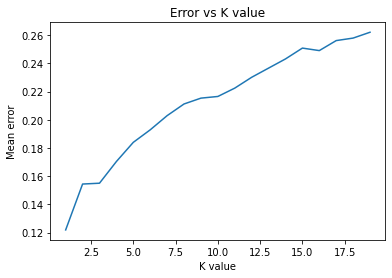

In [14]:
#----------------------------------------------experiments-----------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

error=[]
for i in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    y_predicted=knn.predict(X_test_scaled)
    error.append(np.mean((y_test!=y_predicted)))
    
from matplotlib import pyplot as plt
plt.plot(range(1,20),error)
plt.title('Error vs K value')
plt.xlabel('K value')
plt.ylabel('Mean error')
plt.show

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled,y_train)

y_predicted=knn.predict(X_test_scaled)
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_predicted,y_test)
print('accuracy= ',100*accuracy)

f1_calculater(knn, "KNN")

accuracy=  87.81065088757396
KNN : 
Before merging
0.8781065088757396
After merging
0.9553072625698324
-------------------------------------------------


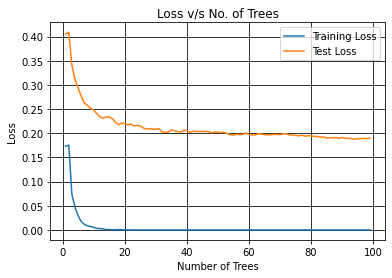

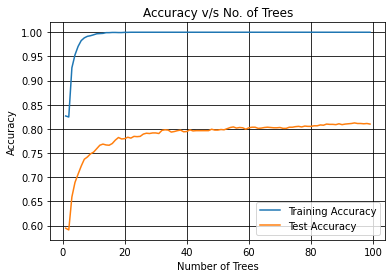

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
loss_train = []
loss_test = []
acc_train = []
acc_test = []
for i in range(1, 100):
    rfc = RandomForestClassifier(n_estimators = i, criterion='entropy', random_state = 48)
    rf = rfc.fit(X_train_scaled, y_train)
    y_pred_1 = rf.predict(X_train_scaled)
    acc_train.append(accuracy_score(y_train, y_pred_1))
    loss_train.append((1-accuracy_score(y_train, y_pred_1)))
    y_pred_2 = rf.predict(X_test_scaled)
    acc_test.append(accuracy_score(y_test, y_pred_2))
    loss_test.append((1-accuracy_score(y_test, y_pred_2)))
    
plt.figure()
plt.plot(range(1, 100), loss_train, label='Training Loss')
plt.plot(range(1, 100), loss_test, label='Test Loss')
plt.legend()
plt.title('Loss v/s No. of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Loss')
plt.grid(c='k')
plt.show()

plt.figure()
plt.plot(range(1, 100), acc_train, label='Training Accuracy')
plt.plot(range(1, 100), acc_test, label='Test Accuracy')
plt.legend()
plt.title('Accuracy v/s No. of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(c='k')
plt.show()

In [17]:
rfc = RandomForestClassifier(n_estimators = 100, criterion='entropy', random_state = 48)
rf = rfc.fit(X_train_scaled, y_train)
f1_calculater(rfc,"Random forest with 50 trees")

Random forest with 50 trees : 
Before merging
0.8094674556213017
After merging
0.888268156424581
-------------------------------------------------


In [18]:
f1_calculater(nb, "Naive Bayes")

#f1_calculater(sgd, "Stochastic Gradient Descent")

f1_calculater(knn, "KNN")

f1_calculater(tree, "Decission trees")

f1_calculater(rforest, "Random Forest")

f1_calculater(svm, "Support Vector Machine")

f1_calculater(lg, "Logistic Regression")

f1_calculater(nn, "Neural Nets")

f1_calculater(xgb, "Cross Gradient Booster")

#f1_calculater(xgbrf, "Cross Gradient Booster (Random Forest)")

Naive Bayes : 
Before merging
0.4603550295857988
After merging
0.5251396648044693
-------------------------------------------------
KNN : 
Before merging
0.8781065088757396
After merging
0.9553072625698324
-------------------------------------------------
Decission trees : 
Before merging
0.6928994082840236
After merging
0.8659217877094972
-------------------------------------------------
Random Forest : 
Before merging
0.736094674556213
After merging
0.8100558659217877
-------------------------------------------------
Support Vector Machine : 
Before merging
0.8047337278106509
After merging
0.888268156424581
-------------------------------------------------
Logistic Regression : 
Before merging
0.5775147928994083
After merging
0.7150837988826816
-------------------------------------------------
Neural Nets : 
Before merging
0.8142011834319527
After merging
0.9385474860335196
-------------------------------------------------
Cross Gradient Booster : 
Before merging
0.7763313609467455
A

In [20]:
# #--------------------------------------------------XGboost grid search-----------------------------------------
# import xgboost as xgb
# #xgb_cl = xgb.XGBClassifier()

# param_grid = {
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1],
#     "reg_lambda": [0, 1, 10],
#     "scale_pos_weight": [1, 3, 5],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5],
# }

# from sklearn.model_selection import GridSearchCV

# # Init classifier
# xgb_cl = xgb.XGBClassifier(objective= 'multi:softmax',tree_method='gpu_hist',use_label_encoder=False)

# # Init Grid Search
# grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="f1_micro",verbose=3)

# # Fit
# _ = grid_cv.fit(X_train_scaled, y_train)



# print('score: ',grid_cv.best_score_)
# print(grid_cv.best_params_)
# f1_calculater(grid_cv, "Cross Gradient Booster with Grid Search")

In [ ]:
# print(param_grid)
# print('---------------------------------------------')
# print(grid_cv.best_params_)

In [ ]:
# print('score: ',grid_cv.best_score_)
# f1_calculater(grid_cv, "Cross Gradient Booster with Grid Search")

# print(grid_cv.best_params_)
# #f1_calculater(xgb_cl, "Cross Gradient Booster with Grid Search")

In [ ]:
# #--------------------------------------------------XGboost grid search-----------------------------------------


# # param_grid = {
# #     "max_depth": [3, 4, 5, 7],
# #     "learning_rate": [0.1, 0.01, 0.05],
# #     "gamma": [0, 0.25, 1],
# #     "reg_lambda": [0, 1, 10],
# #     "scale_pos_weight": [1, 3, 5],
# #     "subsample": [0.8],
# #     "colsample_bytree": [0.5],
# # }

# from sklearn.model_selection import GridSearchCV

# # Init classifier
# xgb_cl = xgb.XGBClassifier(objective= 'multi:softmax',tree_method='gpu_hist',use_label_encoder=False, 
#                            colsample_bytree= 0.5, gamma= 0, learning_rate= 0.1, max_depth= 7, reg_lambda= 1,
#                            scale_pos_weight=1, subsample= 0.8)


# # Fit
# xgb_cl.fit(X_train_scaled, y_train)
# f1_calculater(xgb_cl, "Cross Gradient Booster with Grid Search")

In [ ]:
# #--------------------------------------------------XGboost grid search-----------------------------------------
# #import xgboost as xgb
# #xgb_cl = xgb.XGBClassifier()

# param_grid = {
#     "max_depth": [7,9,11],
#     "learning_rate": [0.01,0.05,0.1],
#     "reg_lambda": [1],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5],
# }

# from sklearn.model_selection import GridSearchCV

# # Init classifier
# xgb_cl = xgb.XGBClassifier(objective= 'multi:softmax',tree_method='gpu_hist',use_label_encoder=False)

# # Init Grid Search
# grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="f1_micro",verbose=3)

# # Fit
# _ = grid_cv.fit(X_train_scaled, y_train)

# print('score: ',grid_cv.best_score_)
# print(grid_cv.best_params_)
# f1_calculater(grid_cv, "Cross Gradient Booster with Grid Search")